In [1]:
import tensorflow as tf

%matplotlib inline
from pylab import *
import matplotlib
matplotlib.rcParams['figure.figsize']=[22, 20]
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from data_loaders import localization_train_loader, make_valid_localization_data

/home/florian/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
digits = load_digits()['data']

tr_digits, tst_digits = train_test_split(digits)
tst_digits, tst_coords = make_valid_localization_data(tst_digits, noise=0.25)

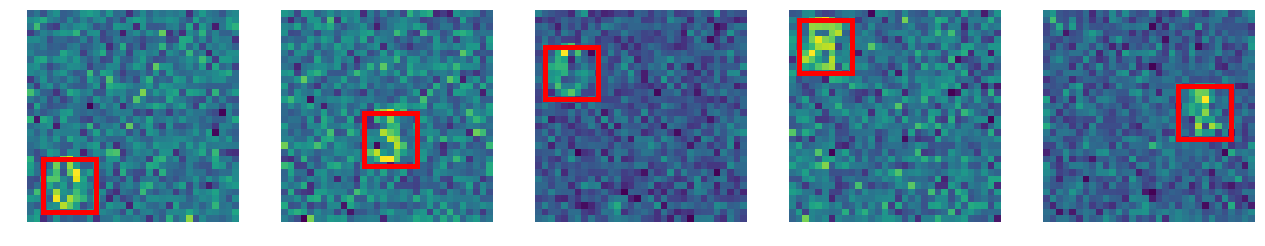

In [3]:
def plot_images(img_array, coord_array, incl_true=False):
    fig, axes = plt.subplots(1, 5)
    for i, row in enumerate(axes):
        axes[i].axis('off')
        # get the coordinates in matplotlib rect format
        x = int(coord_array[i][0] * 32)
        y = int(coord_array[i][2] * 32)
        width = int(coord_array[i][1] * 32) - x
        height = int(coord_array[i][3] * 32) - y
        # add rectangle to the image
        axes[i].add_patch(patches.Rectangle((x, y), 
                                             width, height, fill=False, linewidth=5, color='r'))
        
        # true values are a global variable in this notebook so we'll just pull it from there
        if incl_true:
            # get the coordinates of the true value
            t_x = int(tst_coords[i][0] * 32)
            t_y = int(tst_coords[i][2] * 32)
            t_width = int(tst_coords[i][1] * 32) - x
            t_height = int(tst_coords[i][3] * 32) - y
            # add the true bounding box
            axes[i].add_patch(patches.Rectangle((t_x, t_y), 
                                                 t_width, t_height, fill=False, linewidth=5, linestyle=':', color='y'))
        axes[i].imshow(tst_digits[i].squeeze())
    plt.show()

plot_images(tst_digits, tst_coords)

In [4]:
with tf.name_scope('input_placeholder'):
    X = tf.placeholder(tf.float32, shape=(None, 32, 32, 1), name='X')
    
with tf.name_scope('targets_placeholder'):
    y = tf.placeholder(tf.float32, shape=(None, 4), name='y')

In [5]:
import neural_net_layers as nn

with tf.name_scope('cnn'):
    conv_1 = nn.conv_layer(X, in_dims=1, n_kernels=8, kernel_size=5, name='conv_a', activation=tf.nn.relu)
    pool_1 = nn.max_pool(conv_1, pool_size=2, name='pool_a')
    
    conv_2 = nn.conv_layer(pool_1, in_dims=8, n_kernels=16, kernel_size=5, name='conv_b', activation=tf.nn.relu)
    pool_2 = nn.max_pool(conv_2, pool_size=2, name='pool_b')
    
    # it's important to watch your tensor shapes when using CNNs because you have to flatten
    # the representation for a dense layer, or you may downsample to a 0x0 feature map
    flat = tf.reshape(pool_2, [-1, 8*8*16])
    
    dense = nn.dense_layer(flat, 32, name='dense_layer', activation=tf.nn.relu)
    y_pred = nn.dense_layer(dense, 4, name='output') 

In [6]:
with tf.name_scope('loss'):
    error = y_pred - y
    loss = tf.reduce_mean(tf.square(error), name='mse')
    
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(0.001, name='adam_optimizer').minimize(loss)
    
with tf.name_scope('prediction'):
    predictions = y_pred

In [7]:
EPOCHS = 24

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(EPOCHS):
        loc_loader = localization_train_loader(tr_digits, noise=0.25)
        for X_b, y_b in loc_loader:
            _, train_loss = sess.run([train_step, loss], feed_dict={X: X_b, y: y_b})
            
        if e % 3 == 0:
            print('loss:', train_loss)
            
    saver = tf.train.Saver()
    saver.save(sess, './saved_model/cnn_mnist_loc.ckpt')

loss: 0.030303568
loss: 0.003574774
loss: 0.0010960009
loss: 0.0018980507
loss: 0.0008750336
loss: 0.0016855546
loss: 0.0011969873
loss: 0.0017957961


In [8]:
with tf.Session() as sess:
    saver.restore(sess, './saved_model/cnn_mnist_loc.ckpt')
    preds = sess.run(y_pred, feed_dict={X: tst_digits})

INFO:tensorflow:Restoring parameters from ./saved_model/cnn_mnist_loc.ckpt


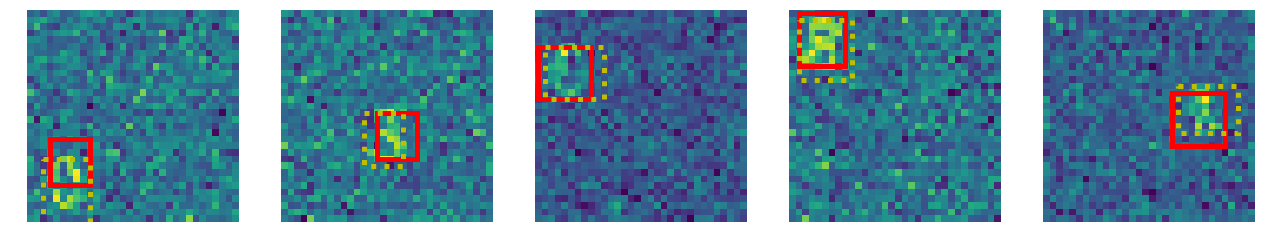

In [9]:
plot_images(tst_digits, preds, incl_true=True)